In [1]:
import tensorflow as tf
import os
import pandas as pd
import numpy as np

1. Load in the csv file. 

In [2]:
df = pd.read_csv('aqi_ny.csv')

2. Drop the extra index.

In [3]:
df = df.drop('Unnamed: 0', axis=1)

In [4]:
df

,date,co,no,no2,o3,so2,pm2_5,pm10,nh3,aqi,latitude,longitude,city
0,2020-12-01 05:00:00,373.84,1.50,43.87,8.49,6.86,9.31,11.75,1.30,2,40.7127,-74.006,"New York, NY"
1,2020-12-01 06:00:00,343.80,1.16,37.70,9.39,7.09,8.43,10.47,1.09,1,40.7127,-74.006,"New York, NY"
2,2020-12-01 07:00:00,337.12,1.79,35.99,6.35,7.21,8.55,10.80,1.08,1,40.7127,-74.006,"New York, NY"
3,2020-12-01 08:00:00,337.12,3.38,34.96,3.09,7.63,8.92,11.57,1.08,1,40.7127,-74.006,"New York, NY"
4,2020-12-01 09:00:00,340.46,5.87,33.59,1.16,8.23,9.62,12.64,1.09,1,40.7127,-74.006,"New York, NY"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
18056,2022-12-31 13:00:00,821.11,62.58,61.69,0.00,5.48,36.08,44.15,3.39,3,40.7127,-74.006,"New York, NY"
18057,2022-12-31 14:00:00,1028.06,92.09,69.23,0.12,6.56,45.75,56.04,3.96,3,40.7127,-74.006,"New York, NY"
18058,2022-12-31 15:00:00,1134.87,104.61,69.23,0.46,8.11,50.21,61.68,4.12,4,40.7127,-74.006,"New York, NY"
18059,2022-12-31 16:00:00,1121.52,101.92,64.43,0.44,9.42,48.14,59.03,4.18,3,40.7127,-74.006,"New York, NY"


3. Make the date column the index, and get rid of the extra date column so there's not a duplicate.

In [5]:
df.index = pd.to_datetime(df['date'])

In [6]:
df = df.drop('date', axis=1)

In [7]:
pm25 = df['pm2_5']

4. Visualize your data. 

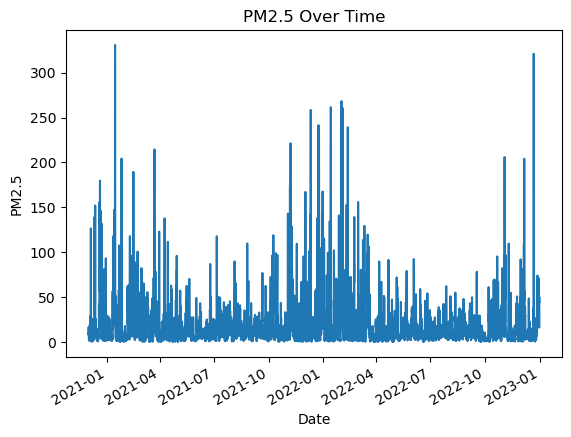

In [8]:
pm25.plot(title= 'PM2.5 Over Time', ylabel = 'PM2.5', xlabel = 'Date');

6. What makes LSTM much better at predicting time series data is that it takes into account a certain amount of values to predict the next one. In this case, the window size is 8, so it is looking at the first 8 values to predict value number 9, next it uses values 2 to 9 to predict 10, and so on. This function gets the data into this format, where X are the predictor values and y is what is being predicted. 

In [9]:
def df_to_X_y(df, window_size=8):
    df_as_np = df.to_numpy()
    X = []
    y = []
    for i in range(len(df_as_np)-window_size):
        row = [[a] for a in df_as_np[i:i+8]]
        X.append(row)
        label = df_as_np[i+5]
        y.append(label)
    return np.array(X), np.array(y)

7. This shows us the shape of X and y, for both there are 18056 arrays, but X has 8 lists in each array since our window size is 8, and y only has one since we are predicting one value at a time. 

In [10]:
window_size = 8
X, y = df_to_X_y(pm25, window_size)
X.shape, y.shape

((18053, 8, 1), (18053,))

8. Split the data into a training set, a validation set, and a testing set. 

In [11]:
X_train, y_train = X[:12000], y[:12000]
X_val, y_val = X[12000:15000], y[12000:15000]
X_test, y_test = X[15000:], y[15000:]
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((12000, 8, 1), (12000,), (3000, 8, 1), (3000,), (3053, 8, 1), (3053,))

In [12]:
from keras.models import Sequential
from keras.layers import *
from keras.callbacks import ModelCheckpoint
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.optimizers import Adam 

9. Create the model. For the first layer you have to specify the shape of your model, since the window size is 8 and we only have one predictor the layer is 8 by 1. Next comes 1 LSTM layer, since LSTM is a neural network you have to specify the number of neurons, 32, 64, 128, and 256 are all common. Two dense layers follow the LSTM layer, the last dense layer is responsible for the regression task, and in this case we specify 1 because we want the output to be 1 predicted value.

In [13]:
model1 = Sequential()
model1.add(InputLayer((8,1)))
model1.add(LSTM(64))
model1.add(Dense(8,'relu'))
model1.add(Dense(1,'linear'))

model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 dense (Dense)               (None, 8)                 520       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 17,425
Trainable params: 17,425
Non-trainable params: 0
_________________________________________________________________


10. Create a checkpoint that saves the best performing model. Just like our XGBoost model, we are using a low learning rate so it will be slower. 

In [14]:
cp = ModelCheckpoint('model1/',save_best_only=True)
model1.compile(loss=MeanSquaredError(), optimizer = Adam(learning_rate=0.0001), metrics=RootMeanSquaredError())

11. Fit the model. The number you choose for your epochs specifies how many times you will run through the data, so the larger the number the longer it will take to run. 

In [15]:
model1.fit(X_train,y_train, validation_data=(X_val,y_val), epochs=50, callbacks=[cp])

Epoch 1/50
369/375 [============================>.] - ETA: 0s - loss: 914.8969 - root_mean_squared_error: 30.2473

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


375/375 [==============================] - 6s 12ms/step - loss: 911.3558 - root_mean_squared_error: 30.1887 - val_loss: 86.0932 - val_root_mean_squared_error: 9.2786
Epoch 2/50
374/375 [============================>.] - ETA: 0s - loss: 687.1358 - root_mean_squared_error: 26.2133

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


375/375 [==============================] - 4s 11ms/step - loss: 686.3568 - root_mean_squared_error: 26.1984 - val_loss: 38.0993 - val_root_mean_squared_error: 6.1725
Epoch 3/50
373/375 [============================>.] - ETA: 0s - loss: 535.4378 - root_mean_squared_error: 23.1395

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


375/375 [==============================] - 4s 11ms/step - loss: 532.9927 - root_mean_squared_error: 23.0866 - val_loss: 21.5463 - val_root_mean_squared_error: 4.6418
Epoch 4/50
369/375 [============================>.] - ETA: 0s - loss: 440.9548 - root_mean_squared_error: 20.9989

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


375/375 [==============================] - 4s 11ms/step - loss: 437.6976 - root_mean_squared_error: 20.9212 - val_loss: 13.7282 - val_root_mean_squared_error: 3.7052
Epoch 5/50
362/375 [===========================>..] - ETA: 0s - loss: 368.0753 - root_mean_squared_error: 19.1853

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


375/375 [==============================] - 4s 11ms/step - loss: 367.8674 - root_mean_squared_error: 19.1799 - val_loss: 9.4078 - val_root_mean_squared_error: 3.0672
Epoch 6/50
363/375 [============================>.] - ETA: 0s - loss: 313.7531 - root_mean_squared_error: 17.7131

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


375/375 [==============================] - 4s 12ms/step - loss: 307.4845 - root_mean_squared_error: 17.5352 - val_loss: 6.8868 - val_root_mean_squared_error: 2.6243
Epoch 7/50
359/375 [===========================>..] - ETA: 0s - loss: 266.6202 - root_mean_squared_error: 16.3285

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


375/375 [==============================] - 4s 11ms/step - loss: 262.6285 - root_mean_squared_error: 16.2058 - val_loss: 4.8725 - val_root_mean_squared_error: 2.2074
Epoch 8/50
371/375 [============================>.] - ETA: 0s - loss: 228.1372 - root_mean_squared_error: 15.1042

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


375/375 [==============================] - 4s 11ms/step - loss: 226.7676 - root_mean_squared_error: 15.0588 - val_loss: 3.4770 - val_root_mean_squared_error: 1.8647
Epoch 9/50
362/375 [===========================>..] - ETA: 0s - loss: 196.3176 - root_mean_squared_error: 14.0113

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


375/375 [==============================] - 4s 11ms/step - loss: 195.4735 - root_mean_squared_error: 13.9812 - val_loss: 2.6038 - val_root_mean_squared_error: 1.6136
Epoch 10/50
362/375 [===========================>..] - ETA: 0s - loss: 173.5025 - root_mean_squared_error: 13.1720

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


375/375 [==============================] - 4s 11ms/step - loss: 169.5441 - root_mean_squared_error: 13.0209 - val_loss: 2.1383 - val_root_mean_squared_error: 1.4623
Epoch 11/50
372/375 [============================>.] - ETA: 0s - loss: 148.7917 - root_mean_squared_error: 12.1980

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


375/375 [==============================] - 4s 11ms/step - loss: 147.6906 - root_mean_squared_error: 12.1528 - val_loss: 1.8542 - val_root_mean_squared_error: 1.3617
Epoch 12/50
372/375 [============================>.] - ETA: 0s - loss: 128.5590 - root_mean_squared_error: 11.3384

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


375/375 [==============================] - 4s 10ms/step - loss: 128.8966 - root_mean_squared_error: 11.3533 - val_loss: 1.4622 - val_root_mean_squared_error: 1.2092
Epoch 13/50
367/375 [============================>.] - ETA: 0s - loss: 111.3303 - root_mean_squared_error: 10.5513

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


375/375 [==============================] - 4s 11ms/step - loss: 112.8678 - root_mean_squared_error: 10.6239 - val_loss: 1.2692 - val_root_mean_squared_error: 1.1266
Epoch 14/50
366/375 [============================>.] - ETA: 0s - loss: 99.0272 - root_mean_squared_error: 9.9512  

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


375/375 [==============================] - 4s 11ms/step - loss: 99.0743 - root_mean_squared_error: 9.9536 - val_loss: 1.1779 - val_root_mean_squared_error: 1.0853
Epoch 15/50
373/375 [============================>.] - ETA: 0s - loss: 87.5631 - root_mean_squared_error: 9.3575

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


375/375 [==============================] - 4s 11ms/step - loss: 87.0983 - root_mean_squared_error: 9.3326 - val_loss: 0.9739 - val_root_mean_squared_error: 0.9869
Epoch 16/50
364/375 [============================>.] - ETA: 0s - loss: 77.7466 - root_mean_squared_error: 8.8174

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


375/375 [==============================] - 4s 12ms/step - loss: 76.8381 - root_mean_squared_error: 8.7657 - val_loss: 0.9068 - val_root_mean_squared_error: 0.9522
Epoch 17/50
375/375 [==============================] - 1s 4ms/step - loss: 67.8895 - root_mean_squared_error: 8.2395 - val_loss: 1.0164 - val_root_mean_squared_error: 1.0082
Epoch 18/50
371/375 [============================>.] - ETA: 0s - loss: 61.1234 - root_mean_squared_error: 7.8181

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


375/375 [==============================] - 4s 11ms/step - loss: 60.4797 - root_mean_squared_error: 7.7769 - val_loss: 0.7750 - val_root_mean_squared_error: 0.8803
Epoch 19/50
360/375 [===========================>..] - ETA: 0s - loss: 54.4299 - root_mean_squared_error: 7.3777

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


375/375 [==============================] - 4s 12ms/step - loss: 53.9518 - root_mean_squared_error: 7.3452 - val_loss: 0.7673 - val_root_mean_squared_error: 0.8760
Epoch 20/50
375/375 [==============================] - 2s 5ms/step - loss: 48.2512 - root_mean_squared_error: 6.9463 - val_loss: 0.7977 - val_root_mean_squared_error: 0.8932
Epoch 21/50
373/375 [============================>.] - ETA: 0s - loss: 43.4893 - root_mean_squared_error: 6.5946

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


375/375 [==============================] - 4s 11ms/step - loss: 43.2733 - root_mean_squared_error: 6.5782 - val_loss: 0.7118 - val_root_mean_squared_error: 0.8437
Epoch 22/50
364/375 [============================>.] - ETA: 0s - loss: 38.4069 - root_mean_squared_error: 6.1973

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


375/375 [==============================] - 4s 11ms/step - loss: 38.8107 - root_mean_squared_error: 6.2298 - val_loss: 0.6784 - val_root_mean_squared_error: 0.8236
Epoch 23/50
367/375 [============================>.] - ETA: 0s - loss: 33.9208 - root_mean_squared_error: 5.8242

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


375/375 [==============================] - 4s 12ms/step - loss: 34.9276 - root_mean_squared_error: 5.9100 - val_loss: 0.6695 - val_root_mean_squared_error: 0.8182
Epoch 24/50
373/375 [============================>.] - ETA: 0s - loss: 31.5628 - root_mean_squared_error: 5.6181

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


375/375 [==============================] - 4s 11ms/step - loss: 31.4076 - root_mean_squared_error: 5.6043 - val_loss: 0.6625 - val_root_mean_squared_error: 0.8139
Epoch 25/50
369/375 [============================>.] - ETA: 0s - loss: 28.7422 - root_mean_squared_error: 5.3612

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


375/375 [==============================] - 4s 12ms/step - loss: 28.3086 - root_mean_squared_error: 5.3206 - val_loss: 0.6321 - val_root_mean_squared_error: 0.7951
Epoch 26/50
375/375 [==============================] - 2s 4ms/step - loss: 25.5786 - root_mean_squared_error: 5.0575 - val_loss: 0.6919 - val_root_mean_squared_error: 0.8318
Epoch 27/50
362/375 [===========================>..] - ETA: 0s - loss: 23.5296 - root_mean_squared_error: 4.8507

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


375/375 [==============================] - 4s 11ms/step - loss: 23.0770 - root_mean_squared_error: 4.8039 - val_loss: 0.6097 - val_root_mean_squared_error: 0.7808
Epoch 28/50
375/375 [==============================] - 2s 4ms/step - loss: 20.8592 - root_mean_squared_error: 4.5672 - val_loss: 0.6111 - val_root_mean_squared_error: 0.7817
Epoch 29/50
362/375 [===========================>..] - ETA: 0s - loss: 19.0082 - root_mean_squared_error: 4.3598

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


375/375 [==============================] - 4s 11ms/step - loss: 18.9668 - root_mean_squared_error: 4.3551 - val_loss: 0.5850 - val_root_mean_squared_error: 0.7649
Epoch 30/50
375/375 [==============================] - 2s 4ms/step - loss: 17.2071 - root_mean_squared_error: 4.1481 - val_loss: 0.5859 - val_root_mean_squared_error: 0.7655
Epoch 31/50
364/375 [============================>.] - ETA: 0s - loss: 16.0291 - root_mean_squared_error: 4.0036

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


375/375 [==============================] - 4s 12ms/step - loss: 15.6082 - root_mean_squared_error: 3.9507 - val_loss: 0.5552 - val_root_mean_squared_error: 0.7451
Epoch 32/50
369/375 [============================>.] - ETA: 0s - loss: 14.3730 - root_mean_squared_error: 3.7912

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


375/375 [==============================] - 4s 11ms/step - loss: 14.1591 - root_mean_squared_error: 3.7629 - val_loss: 0.5267 - val_root_mean_squared_error: 0.7257
Epoch 33/50
375/375 [==============================] - 2s 4ms/step - loss: 12.8085 - root_mean_squared_error: 3.5789 - val_loss: 0.5318 - val_root_mean_squared_error: 0.7292
Epoch 34/50
375/375 [==============================] - 1s 4ms/step - loss: 11.5771 - root_mean_squared_error: 3.4025 - val_loss: 0.5314 - val_root_mean_squared_error: 0.7290
Epoch 35/50
368/375 [============================>.] - ETA: 0s - loss: 10.6794 - root_mean_squared_error: 3.2679

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


375/375 [==============================] - 4s 12ms/step - loss: 10.6262 - root_mean_squared_error: 3.2598 - val_loss: 0.4762 - val_root_mean_squared_error: 0.6901
Epoch 36/50
375/375 [==============================] - 1s 4ms/step - loss: 9.5845 - root_mean_squared_error: 3.0959 - val_loss: 0.4963 - val_root_mean_squared_error: 0.7045
Epoch 37/50
370/375 [============================>.] - ETA: 0s - loss: 8.5895 - root_mean_squared_error: 2.9308

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


375/375 [==============================] - 4s 11ms/step - loss: 8.7484 - root_mean_squared_error: 2.9578 - val_loss: 0.4755 - val_root_mean_squared_error: 0.6895
Epoch 38/50
374/375 [============================>.] - ETA: 0s - loss: 8.1938 - root_mean_squared_error: 2.8625

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


375/375 [==============================] - 4s 11ms/step - loss: 8.1745 - root_mean_squared_error: 2.8591 - val_loss: 0.4231 - val_root_mean_squared_error: 0.6504
Epoch 39/50
375/375 [==============================] - 2s 4ms/step - loss: 7.4958 - root_mean_squared_error: 2.7379 - val_loss: 0.4604 - val_root_mean_squared_error: 0.6785
Epoch 40/50
375/375 [==============================] - 2s 4ms/step - loss: 6.7506 - root_mean_squared_error: 2.5982 - val_loss: 0.4242 - val_root_mean_squared_error: 0.6513
Epoch 41/50
369/375 [============================>.] - ETA: 0s - loss: 6.4402 - root_mean_squared_error: 2.5378

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


375/375 [==============================] - 4s 12ms/step - loss: 6.3576 - root_mean_squared_error: 2.5214 - val_loss: 0.3730 - val_root_mean_squared_error: 0.6108
Epoch 42/50
375/375 [==============================] - 1s 4ms/step - loss: 5.8148 - root_mean_squared_error: 2.4114 - val_loss: 0.3773 - val_root_mean_squared_error: 0.6142
Epoch 43/50
361/375 [===========================>..] - ETA: 0s - loss: 5.4504 - root_mean_squared_error: 2.3346

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


375/375 [==============================] - 4s 11ms/step - loss: 5.3995 - root_mean_squared_error: 2.3237 - val_loss: 0.3452 - val_root_mean_squared_error: 0.5876
Epoch 44/50
375/375 [==============================] - 2s 4ms/step - loss: 5.0343 - root_mean_squared_error: 2.2437 - val_loss: 0.3512 - val_root_mean_squared_error: 0.5926
Epoch 45/50
375/375 [==============================] - ETA: 0s - loss: 4.8151 - root_mean_squared_error: 2.1943

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


375/375 [==============================] - 5s 12ms/step - loss: 4.8151 - root_mean_squared_error: 2.1943 - val_loss: 0.3178 - val_root_mean_squared_error: 0.5638
Epoch 46/50
366/375 [============================>.] - ETA: 0s - loss: 4.5520 - root_mean_squared_error: 2.1335

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


375/375 [==============================] - 4s 11ms/step - loss: 4.5195 - root_mean_squared_error: 2.1259 - val_loss: 0.2956 - val_root_mean_squared_error: 0.5437
Epoch 47/50
370/375 [============================>.] - ETA: 0s - loss: 4.2638 - root_mean_squared_error: 2.0649

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


375/375 [==============================] - 4s 11ms/step - loss: 4.2330 - root_mean_squared_error: 2.0574 - val_loss: 0.2747 - val_root_mean_squared_error: 0.5241
Epoch 48/50
375/375 [==============================] - ETA: 0s - loss: 3.9259 - root_mean_squared_error: 1.9814

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


375/375 [==============================] - 4s 12ms/step - loss: 3.9259 - root_mean_squared_error: 1.9814 - val_loss: 0.2640 - val_root_mean_squared_error: 0.5138
Epoch 49/50
375/375 [==============================] - 2s 4ms/step - loss: 3.8304 - root_mean_squared_error: 1.9572 - val_loss: 0.2717 - val_root_mean_squared_error: 0.5212
Epoch 50/50
370/375 [============================>.] - ETA: 0s - loss: 3.6370 - root_mean_squared_error: 1.9071

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


375/375 [==============================] - 4s 11ms/step - loss: 3.6192 - root_mean_squared_error: 1.9024 - val_loss: 0.2553 - val_root_mean_squared_error: 0.5053


In [16]:
from keras.models import load_model

12. Load the model so we can work with the best one. 

In [17]:
model1 = load_model('model1/')

13. Calculate the predicted values for the training set and add them to a dataframe with the actuals.

In [18]:
train_predictions = model1.predict(X_train).flatten()
train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_train})
train_results

375/375 [==============================] - 1s 2ms/step


,Train Predictions,Actuals
0,10.666890,10.60
1,12.249108,11.92
2,15.180731,15.04
3,16.873922,16.85
4,16.047186,15.64
...,...,...
11995,2.556515,2.45
11996,2.987394,2.90
11997,3.628376,3.48
11998,4.687016,4.54


14. Visualize the data to compare predicted values to the actual values for the training set. As you can see, the model did a very good job of predicting values since the lines are pretty much on top of each other.

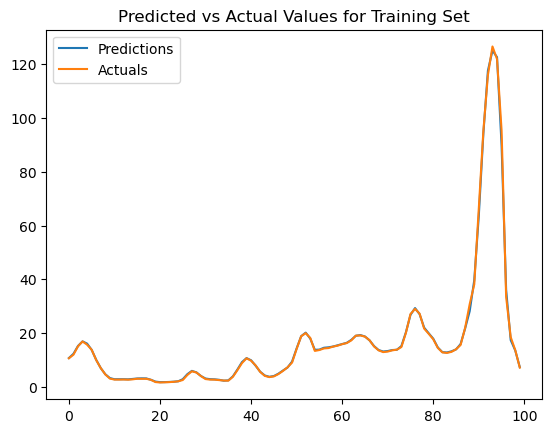

In [19]:
import matplotlib.pyplot as plt
plt.plot(train_results['Train Predictions'][:100])
plt.plot(train_results['Actuals'][:100])
plt.title('Predicted vs Actual Values for Training Set')
plt.legend(['Predictions','Actuals']);

15. Calculate the predicted values for the validation set and add them to a dataframe with the actuals.

In [20]:
val_predictions = model1.predict(X_val).flatten()
val_results = pd.DataFrame(data={'Val Predictions':val_predictions, 'Actuals':y_val})
val_results

94/94 [==============================] - 1s 2ms/step


,Val Predictions,Actuals
0,8.172602,7.60
1,12.012500,11.78
2,11.432067,12.08
3,6.672570,5.95
4,6.900505,6.47
...,...,...
2995,20.646208,20.61
2996,19.847719,19.86
2997,18.616465,18.63
2998,17.971292,17.85


16. Visualize the data to compare predicted values to the actual values for the validation set. Again, it looks like the model did a good job of predicting values. 

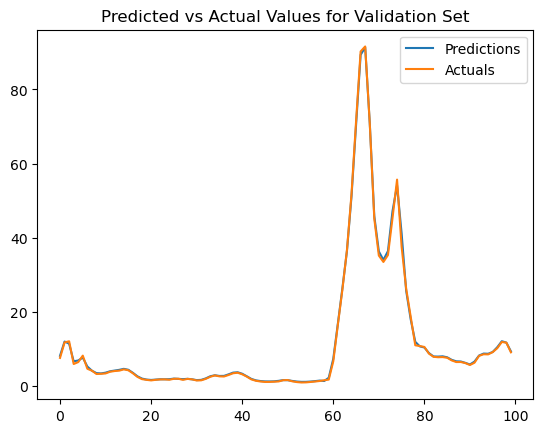

In [21]:
plt.plot(val_results['Val Predictions'][:100])
plt.plot(val_results['Actuals'][:100])
plt.title('Predicted vs Actual Values for Validation Set')
plt.legend(['Predictions','Actuals']);

17. Calculate the predicted values for the test set and add them to a dataframe along with the actuals.

In [22]:
test_predictions = model1.predict(X_test).flatten()
test_results = pd.DataFrame(data={'Test Predictions':test_predictions, 'Actuals':y_test})
test_results

96/96 [==============================] - 0s 2ms/step


,Test Predictions,Actuals
0,18.619696,18.85
1,17.085001,16.84
2,17.768051,17.90
3,19.581669,19.42
4,22.733467,22.37
...,...,...
3048,16.273369,16.50
3049,17.788172,17.82
3050,24.376644,24.86
3051,36.138786,36.08


18. Visualize the data to compare predicted values to the actual values for the test set. This time, it looks like the model struggled a bit when predicting those first two larger spikes. But overall, it looks like the model performed well again.  

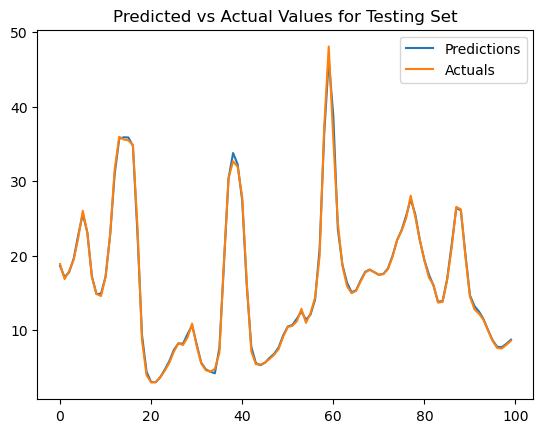

In [23]:
plt.plot(test_results['Test Predictions'][:100])
plt.plot(test_results['Actuals'][:100])
plt.title('Predicted vs Actual Values for Testing Set')
plt.legend(['Predictions','Actuals']);

In [24]:
from sklearn.metrics import r2_score

19. Calculate the coefficient of determination for the training set, validation set, and testing set. As you can see, the model performed very well, especially when you consider that we did not have to add any extra features like we had to for the XGBoost model. When we tested the XGBoost model's training score with no added features it was .12, so this model performs much better at its most basic level. 

In [25]:
train_r2 = r2_score(train_results['Actuals'],train_results['Train Predictions'])
train_r2

0.9953179667528899

In [26]:
val_r2 = r2_score(val_results['Actuals'],val_results['Val Predictions'])
val_r2

0.9975792426945416

In [27]:
test_r2 = r2_score(test_results['Actuals'],test_results['Test Predictions'])
test_r2

0.9867484692913726

In [80]:
from sklearn.metrics import mean_squared_error 

20. Calculate the Mean Squared Error and the Root Mean Squared Error. The MSE for the XGBoost model's training set was 40.62, while this model's MSE is much lower at 3.37. 

In [81]:
realVals_train = train_results.Actuals
predictedVals_train = train_results['Train Predictions']
mse_train = mean_squared_error(realVals_train, predictedVals_train)
mse_train

3.3713840136986875

In [84]:
realVals_train = train_results.Actuals
predictedVals_train = train_results['Train Predictions']
rmse_train = mean_squared_error(realVals_train, predictedVals_train, squared = False)
rmse_train

1.8361328965242922

In [82]:
realVals_val = val_results.Actuals
predictedVals_val = val_results['Val Predictions']
mse_val = mean_squared_error(realVals_val, predictedVals_val)
mse_val

0.2553162001928015

In [85]:
realVals_val = val_results.Actuals
predictedVals_val = val_results['Val Predictions']
rmse_val = mean_squared_error(realVals_val, predictedVals_val, squared = False)
rmse_val

0.5052882347658626

In [83]:
realVals_test = test_results.Actuals
predictedVals_test = test_results['Test Predictions']
mse_test = mean_squared_error(realVals_test, predictedVals_test)
mse_test

7.7237230470563585

In [86]:
realVals_test = test_results.Actuals
predictedVals_test = test_results['Test Predictions']
rmse_test = mean_squared_error(realVals_test, predictedVals_test, squared = False)
rmse_test

2.7791586941116475

21. Create a second model. This time we are adding features to help it get a better sense of how the data progresses with time so that its performance is hopefully improved. As we saw before, this is not as necessary as when you use XGBoost to predict time series data, but we want to try and refine our model. 

In [28]:
pm25_df = pd.DataFrame({'pm2_5':pm25})
pm25_df['seconds'] = pm25_df.index.map(pd.Timestamp.timestamp)
pm25_df

,pm2_5,seconds
date,,
2020-12-01 05:00:00,9.31,1.606799e+09
2020-12-01 06:00:00,8.43,1.606802e+09
2020-12-01 07:00:00,8.55,1.606806e+09
2020-12-01 08:00:00,8.92,1.606810e+09
2020-12-01 09:00:00,9.62,1.606813e+09
...,...,...
2022-12-31 13:00:00,36.08,1.672492e+09
2022-12-31 14:00:00,45.75,1.672495e+09
2022-12-31 15:00:00,50.21,1.672499e+09


22. Use the seconds column to create columns for Day sin, Day cos, Year sin, and Year cos. These features are similar to the lag features that we used for our XGBoost model in that they are there to give a sense of relative time, but these are referred to as cyclical features. 

In [29]:
day = 60*60*24
year = 365.2425*day 

pm25_df['Day sin'] = np.sin(pm25_df['seconds'] * (2*np.pi / day))
pm25_df['Day cos'] = np.cos(pm25_df['seconds'] * (2*np.pi / day))
pm25_df['Year sin'] = np.sin(pm25_df['seconds'] * (2*np.pi / year))
pm25_df['Year cos'] = np.cos(pm25_df['seconds'] * (2*np.pi / year))

In [30]:
pm25_df

,pm2_5,seconds,Day sin,Day cos,Year sin,Year cos
date,,,,,,
2020-12-01 05:00:00,9.31,1.606799e+09,0.965926,2.588190e-01,-0.495857,0.868404
2020-12-01 06:00:00,8.43,1.606802e+09,1.000000,1.086286e-11,-0.495234,0.868759
2020-12-01 07:00:00,8.55,1.606806e+09,0.965926,-2.588190e-01,-0.494612,0.869114
2020-12-01 08:00:00,8.92,1.606810e+09,0.866025,-5.000000e-01,-0.493988,0.869468
2020-12-01 09:00:00,9.62,1.606813e+09,0.707107,-7.071068e-01,-0.493365,0.869822
...,...,...,...,...,...,...
2022-12-31 13:00:00,36.08,1.672492e+09,-0.258819,-9.659258e-01,-0.005347,0.999986
2022-12-31 14:00:00,45.75,1.672495e+09,-0.500000,-8.660254e-01,-0.004630,0.999989
2022-12-31 15:00:00,50.21,1.672499e+09,-0.707107,-7.071068e-01,-0.003914,0.999992


23. Drop the seconds column since it is no longer necessary now that we have created the extra columns. 

In [31]:
aqi_df = pm25_df.drop('seconds', axis=1)

In [32]:
aqi_df

,pm2_5,Day sin,Day cos,Year sin,Year cos
date,,,,,
2020-12-01 05:00:00,9.31,0.965926,2.588190e-01,-0.495857,0.868404
2020-12-01 06:00:00,8.43,1.000000,1.086286e-11,-0.495234,0.868759
2020-12-01 07:00:00,8.55,0.965926,-2.588190e-01,-0.494612,0.869114
2020-12-01 08:00:00,8.92,0.866025,-5.000000e-01,-0.493988,0.869468
2020-12-01 09:00:00,9.62,0.707107,-7.071068e-01,-0.493365,0.869822
...,...,...,...,...,...
2022-12-31 13:00:00,36.08,-0.258819,-9.659258e-01,-0.005347,0.999986
2022-12-31 14:00:00,45.75,-0.500000,-8.660254e-01,-0.004630,0.999989
2022-12-31 15:00:00,50.21,-0.707107,-7.071068e-01,-0.003914,0.999992


24. This is the same function as before, but it makes it so that there are 8 lists in each array since the window size is 8, and each array has 5 values since we have 5 features now (PM2.5, day sin, day cos, year sin, and year cos).

In [33]:
def df_to_X_y2(df, window_size=8):
    df_as_np = df.to_numpy()
    X = []
    y = []
    for i in range(len(df_as_np)-window_size):
        row = [r for r in df_as_np[i:i+window_size]]
        X.append(row)
        label = df_as_np[i+window_size][0]
        y.append(label)
    return np.array(X), np.array(y)

In [34]:
X2, y2 = df_to_X_y2(aqi_df)
X2.shape, y2.shape 

((18053, 8, 5), (18053,))

25. Separate the data into a training set, a validation set, and a testing set. 

In [35]:
X2_train, y2_train = X2[:12000], y2[:12000]
X2_val, y2_val = X2[12000:15000], y2[12000:15000]
X2_test, y2_test = X2[15000:], y2[15000:]
X2_train.shape, y2_train.shape, X2_val.shape, y2_val.shape, X2_test.shape, y2_test.shape

((12000, 8, 5), (12000,), (3000, 8, 5), (3000,), (3053, 8, 5), (3053,))

26. Standardize the data so that all the values are on a similar scale. 

In [36]:
pm25_training_mean = np.mean(X2_train[:, :, 0])
pm25_training_std = np.std(X2_train[:, :, 0])

def preprocess(X):
    X[:, :, 0] = (X[:, :, 0] - pm25_training_mean) / pm25_training_std
    return X

In [37]:
preprocess(X2_train)
preprocess(X2_val)
preprocess(X2_test)

array([[[ 7.63055244e-02,  9.65925826e-01,  2.58819045e-01,
         -7.79677220e-01, -6.26181629e-01],
        [ 4.83556901e-02,  1.00000000e+00,  9.43975630e-12,
         -7.80125855e-01, -6.25622610e-01],
        [ 2.51796176e-03,  9.65925826e-01, -2.58819045e-01,
         -7.80574090e-01, -6.25063269e-01],
        ...,
        [ 1.07165798e-02,  5.00000000e-01, -8.66025404e-01,
         -7.81916387e-01, -6.23383320e-01],
        [-6.41889762e-02,  2.58819045e-01, -9.65925826e-01,
         -7.82363017e-01, -6.22822696e-01],
        [-2.46865437e-02,  1.20031004e-11, -1.00000000e+00,
         -7.82809244e-01, -6.22261752e-01]],

       [[ 4.83556901e-02,  1.00000000e+00,  9.43975630e-12,
         -7.80125855e-01, -6.25622610e-01],
        [ 2.51796176e-03,  9.65925826e-01, -2.58819045e-01,
         -7.80574090e-01, -6.25063269e-01],
        [-2.65498660e-02,  8.66025404e-01, -5.00000000e-01,
         -7.81021924e-01, -6.24503606e-01],
        ...,
        [-6.41889762e-02,  2.5881904

27. Create the model, everything stays the same as the first attempt but the InputLayer since the dimensions have now changed because we added those extra time features. 

In [38]:
model2 = Sequential()
model2.add(InputLayer((8, 5)))
model2.add(LSTM(64))
model2.add(Dense(8,'relu'))
model2.add(Dense(1,'linear'))

model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 64)                17920     
                                                                 
 dense_2 (Dense)             (None, 8)                 520       
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                                 
Total params: 18,449
Trainable params: 18,449
Non-trainable params: 0
_________________________________________________________________


28. Create the checkpoint to save the best model.

In [39]:
cp2 = ModelCheckpoint('model2/',save_best_only=True)
model2.compile(loss=MeanSquaredError(), optimizer = Adam(learning_rate=0.0001), metrics=RootMeanSquaredError())

29. Fit the model.

In [40]:
model2.fit(X2_train,y2_train, validation_data=(X2_val,y2_val), epochs=50, callbacks=[cp2])

Epoch 1/50
365/375 [============================>.] - ETA: 0s - loss: 1061.3296 - root_mean_squared_error: 32.5781

INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


375/375 [==============================] - 5s 12ms/step - loss: 1055.7140 - root_mean_squared_error: 32.4918 - val_loss: 235.7178 - val_root_mean_squared_error: 15.3531
Epoch 2/50
367/375 [============================>.] - ETA: 0s - loss: 915.6664 - root_mean_squared_error: 30.2600

INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


375/375 [==============================] - 4s 12ms/step - loss: 905.1529 - root_mean_squared_error: 30.0858 - val_loss: 117.0269 - val_root_mean_squared_error: 10.8179
Epoch 3/50
369/375 [============================>.] - ETA: 0s - loss: 793.2589 - root_mean_squared_error: 28.1649

INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


375/375 [==============================] - 4s 12ms/step - loss: 792.5523 - root_mean_squared_error: 28.1523 - val_loss: 98.4469 - val_root_mean_squared_error: 9.9220
Epoch 4/50
361/375 [===========================>..] - ETA: 0s - loss: 739.2818 - root_mean_squared_error: 27.1897

INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


375/375 [==============================] - 5s 12ms/step - loss: 731.1302 - root_mean_squared_error: 27.0394 - val_loss: 83.9923 - val_root_mean_squared_error: 9.1647
Epoch 5/50
366/375 [============================>.] - ETA: 0s - loss: 683.3988 - root_mean_squared_error: 26.1419

INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


375/375 [==============================] - 4s 11ms/step - loss: 679.6935 - root_mean_squared_error: 26.0709 - val_loss: 79.7502 - val_root_mean_squared_error: 8.9303
Epoch 6/50
361/375 [===========================>..] - ETA: 0s - loss: 644.6014 - root_mean_squared_error: 25.3890

INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


375/375 [==============================] - 4s 12ms/step - loss: 636.8136 - root_mean_squared_error: 25.2352 - val_loss: 75.7298 - val_root_mean_squared_error: 8.7023
Epoch 7/50
362/375 [===========================>..] - ETA: 0s - loss: 591.0374 - root_mean_squared_error: 24.3113

INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


375/375 [==============================] - 4s 11ms/step - loss: 596.2266 - root_mean_squared_error: 24.4178 - val_loss: 69.6186 - val_root_mean_squared_error: 8.3438
Epoch 8/50
365/375 [============================>.] - ETA: 0s - loss: 553.9276 - root_mean_squared_error: 23.5357

INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


375/375 [==============================] - 5s 13ms/step - loss: 556.2819 - root_mean_squared_error: 23.5856 - val_loss: 63.8052 - val_root_mean_squared_error: 7.9878
Epoch 9/50
372/375 [============================>.] - ETA: 0s - loss: 519.0756 - root_mean_squared_error: 22.7832

INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


375/375 [==============================] - 4s 12ms/step - loss: 516.1091 - root_mean_squared_error: 22.7180 - val_loss: 55.6707 - val_root_mean_squared_error: 7.4613
Epoch 10/50
363/375 [============================>.] - ETA: 0s - loss: 480.7940 - root_mean_squared_error: 21.9270

INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


375/375 [==============================] - 5s 13ms/step - loss: 477.4693 - root_mean_squared_error: 21.8511 - val_loss: 49.4326 - val_root_mean_squared_error: 7.0308
Epoch 11/50
364/375 [============================>.] - ETA: 0s - loss: 445.5125 - root_mean_squared_error: 21.1072

INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


375/375 [==============================] - 4s 12ms/step - loss: 441.5616 - root_mean_squared_error: 21.0134 - val_loss: 43.8904 - val_root_mean_squared_error: 6.6250
Epoch 12/50
372/375 [============================>.] - ETA: 0s - loss: 405.5172 - root_mean_squared_error: 20.1375

INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


375/375 [==============================] - 4s 12ms/step - loss: 407.8955 - root_mean_squared_error: 20.1964 - val_loss: 40.1828 - val_root_mean_squared_error: 6.3390
Epoch 13/50
362/375 [===========================>..] - ETA: 0s - loss: 377.5578 - root_mean_squared_error: 19.4308

INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


375/375 [==============================] - 4s 12ms/step - loss: 376.2623 - root_mean_squared_error: 19.3975 - val_loss: 36.7439 - val_root_mean_squared_error: 6.0617
Epoch 14/50
372/375 [============================>.] - ETA: 0s - loss: 348.7249 - root_mean_squared_error: 18.6742

INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


375/375 [==============================] - 5s 12ms/step - loss: 346.6588 - root_mean_squared_error: 18.6188 - val_loss: 33.3677 - val_root_mean_squared_error: 5.7765
Epoch 15/50
368/375 [============================>.] - ETA: 0s - loss: 321.1473 - root_mean_squared_error: 17.9206

INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


375/375 [==============================] - 5s 12ms/step - loss: 318.7524 - root_mean_squared_error: 17.8536 - val_loss: 28.7060 - val_root_mean_squared_error: 5.3578
Epoch 16/50
364/375 [============================>.] - ETA: 0s - loss: 291.9092 - root_mean_squared_error: 17.0854

INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


375/375 [==============================] - 4s 12ms/step - loss: 293.2596 - root_mean_squared_error: 17.1248 - val_loss: 26.4800 - val_root_mean_squared_error: 5.1459
Epoch 17/50
362/375 [===========================>..] - ETA: 0s - loss: 272.6180 - root_mean_squared_error: 16.5111

INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


375/375 [==============================] - 5s 13ms/step - loss: 269.9842 - root_mean_squared_error: 16.4312 - val_loss: 24.3526 - val_root_mean_squared_error: 4.9348
Epoch 18/50
375/375 [==============================] - ETA: 0s - loss: 249.1600 - root_mean_squared_error: 15.7848

INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


375/375 [==============================] - 5s 12ms/step - loss: 249.1600 - root_mean_squared_error: 15.7848 - val_loss: 21.9719 - val_root_mean_squared_error: 4.6874
Epoch 19/50
373/375 [============================>.] - ETA: 0s - loss: 230.6013 - root_mean_squared_error: 15.1856

INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


375/375 [==============================] - 5s 13ms/step - loss: 229.9219 - root_mean_squared_error: 15.1632 - val_loss: 20.5493 - val_root_mean_squared_error: 4.5331
Epoch 20/50
364/375 [============================>.] - ETA: 0s - loss: 213.6753 - root_mean_squared_error: 14.6176

INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


375/375 [==============================] - 5s 12ms/step - loss: 212.5692 - root_mean_squared_error: 14.5798 - val_loss: 18.6678 - val_root_mean_squared_error: 4.3206
Epoch 21/50
372/375 [============================>.] - ETA: 0s - loss: 194.9810 - root_mean_squared_error: 13.9636

INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


375/375 [==============================] - 5s 13ms/step - loss: 196.4325 - root_mean_squared_error: 14.0154 - val_loss: 17.0380 - val_root_mean_squared_error: 4.1277
Epoch 22/50
368/375 [============================>.] - ETA: 0s - loss: 177.3093 - root_mean_squared_error: 13.3158

INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


375/375 [==============================] - 5s 14ms/step - loss: 181.6924 - root_mean_squared_error: 13.4793 - val_loss: 15.7427 - val_root_mean_squared_error: 3.9677
Epoch 23/50
375/375 [==============================] - ETA: 0s - loss: 168.2686 - root_mean_squared_error: 12.9718

INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


375/375 [==============================] - 5s 14ms/step - loss: 168.2686 - root_mean_squared_error: 12.9718 - val_loss: 14.4672 - val_root_mean_squared_error: 3.8036
Epoch 24/50
372/375 [============================>.] - ETA: 0s - loss: 156.0143 - root_mean_squared_error: 12.4906

INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


375/375 [==============================] - 5s 13ms/step - loss: 156.1369 - root_mean_squared_error: 12.4955 - val_loss: 13.7648 - val_root_mean_squared_error: 3.7101
Epoch 25/50
364/375 [============================>.] - ETA: 0s - loss: 142.4126 - root_mean_squared_error: 11.9337

INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


375/375 [==============================] - 5s 14ms/step - loss: 145.0992 - root_mean_squared_error: 12.0457 - val_loss: 12.9035 - val_root_mean_squared_error: 3.5921
Epoch 26/50
375/375 [==============================] - ETA: 0s - loss: 135.0758 - root_mean_squared_error: 11.6222

INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


375/375 [==============================] - 5s 14ms/step - loss: 135.0758 - root_mean_squared_error: 11.6222 - val_loss: 12.7196 - val_root_mean_squared_error: 3.5665
Epoch 27/50
367/375 [============================>.] - ETA: 0s - loss: 126.1694 - root_mean_squared_error: 11.2325

INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


375/375 [==============================] - 6s 15ms/step - loss: 125.9486 - root_mean_squared_error: 11.2227 - val_loss: 11.8129 - val_root_mean_squared_error: 3.4370
Epoch 28/50
374/375 [============================>.] - ETA: 0s - loss: 117.6688 - root_mean_squared_error: 10.8475

INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


375/375 [==============================] - 5s 15ms/step - loss: 117.5295 - root_mean_squared_error: 10.8411 - val_loss: 11.2182 - val_root_mean_squared_error: 3.3494
Epoch 29/50
370/375 [============================>.] - ETA: 0s - loss: 109.7390 - root_mean_squared_error: 10.4756

INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


375/375 [==============================] - 5s 15ms/step - loss: 109.9122 - root_mean_squared_error: 10.4839 - val_loss: 10.7516 - val_root_mean_squared_error: 3.2790
Epoch 30/50
368/375 [============================>.] - ETA: 0s - loss: 104.3570 - root_mean_squared_error: 10.2155

INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


375/375 [==============================] - 5s 13ms/step - loss: 103.1134 - root_mean_squared_error: 10.1545 - val_loss: 10.5002 - val_root_mean_squared_error: 3.2404
Epoch 31/50
370/375 [============================>.] - ETA: 0s - loss: 97.6323 - root_mean_squared_error: 9.8809

INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


375/375 [==============================] - 5s 14ms/step - loss: 96.6868 - root_mean_squared_error: 9.8329 - val_loss: 10.2036 - val_root_mean_squared_error: 3.1943
Epoch 32/50
369/375 [============================>.] - ETA: 0s - loss: 91.6511 - root_mean_squared_error: 9.5735

INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


375/375 [==============================] - 5s 13ms/step - loss: 90.8998 - root_mean_squared_error: 9.5341 - val_loss: 9.8441 - val_root_mean_squared_error: 3.1375
Epoch 33/50
367/375 [============================>.] - ETA: 0s - loss: 86.6475 - root_mean_squared_error: 9.3085

INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


375/375 [==============================] - 5s 14ms/step - loss: 85.5529 - root_mean_squared_error: 9.2495 - val_loss: 9.6791 - val_root_mean_squared_error: 3.1111
Epoch 34/50
366/375 [============================>.] - ETA: 0s - loss: 80.4059 - root_mean_squared_error: 8.9669

INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


375/375 [==============================] - 5s 14ms/step - loss: 80.8108 - root_mean_squared_error: 8.9895 - val_loss: 9.3821 - val_root_mean_squared_error: 3.0630
Epoch 35/50
375/375 [==============================] - ETA: 0s - loss: 76.4642 - root_mean_squared_error: 8.7444

INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


375/375 [==============================] - 5s 15ms/step - loss: 76.4642 - root_mean_squared_error: 8.7444 - val_loss: 9.0553 - val_root_mean_squared_error: 3.0092
Epoch 36/50
372/375 [============================>.] - ETA: 0s - loss: 72.7022 - root_mean_squared_error: 8.5266

INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


375/375 [==============================] - 5s 13ms/step - loss: 72.4102 - root_mean_squared_error: 8.5094 - val_loss: 8.8699 - val_root_mean_squared_error: 2.9782
Epoch 37/50
372/375 [============================>.] - ETA: 0s - loss: 65.2537 - root_mean_squared_error: 8.0780

INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


375/375 [==============================] - 5s 15ms/step - loss: 68.6569 - root_mean_squared_error: 8.2859 - val_loss: 8.6634 - val_root_mean_squared_error: 2.9434
Epoch 38/50
375/375 [==============================] - ETA: 0s - loss: 65.2820 - root_mean_squared_error: 8.0797

INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


375/375 [==============================] - 5s 14ms/step - loss: 65.2820 - root_mean_squared_error: 8.0797 - val_loss: 8.6531 - val_root_mean_squared_error: 2.9416
Epoch 39/50
375/375 [==============================] - ETA: 0s - loss: 62.1370 - root_mean_squared_error: 7.8827

INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


375/375 [==============================] - 6s 15ms/step - loss: 62.1370 - root_mean_squared_error: 7.8827 - val_loss: 8.4648 - val_root_mean_squared_error: 2.9094
Epoch 40/50
375/375 [==============================] - 2s 6ms/step - loss: 59.3710 - root_mean_squared_error: 7.7053 - val_loss: 8.4793 - val_root_mean_squared_error: 2.9119
Epoch 41/50
371/375 [============================>.] - ETA: 0s - loss: 54.3931 - root_mean_squared_error: 7.3752

INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


375/375 [==============================] - 5s 14ms/step - loss: 56.7119 - root_mean_squared_error: 7.5307 - val_loss: 8.3916 - val_root_mean_squared_error: 2.8968
Epoch 42/50
375/375 [==============================] - 2s 6ms/step - loss: 54.3025 - root_mean_squared_error: 7.3690 - val_loss: 8.4983 - val_root_mean_squared_error: 2.9152
Epoch 43/50
368/375 [============================>.] - ETA: 0s - loss: 51.9511 - root_mean_squared_error: 7.2077

INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


375/375 [==============================] - 5s 13ms/step - loss: 52.0409 - root_mean_squared_error: 7.2139 - val_loss: 8.2115 - val_root_mean_squared_error: 2.8656
Epoch 44/50
371/375 [============================>.] - ETA: 0s - loss: 50.2731 - root_mean_squared_error: 7.0904

INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


375/375 [==============================] - 6s 15ms/step - loss: 49.8659 - root_mean_squared_error: 7.0616 - val_loss: 8.0305 - val_root_mean_squared_error: 2.8338
Epoch 45/50
370/375 [============================>.] - ETA: 0s - loss: 48.4346 - root_mean_squared_error: 6.9595

INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


375/375 [==============================] - 6s 16ms/step - loss: 47.9594 - root_mean_squared_error: 6.9253 - val_loss: 7.9400 - val_root_mean_squared_error: 2.8178
Epoch 46/50
375/375 [==============================] - 2s 6ms/step - loss: 46.2271 - root_mean_squared_error: 6.7990 - val_loss: 7.9926 - val_root_mean_squared_error: 2.8271
Epoch 47/50
371/375 [============================>.] - ETA: 0s - loss: 44.7997 - root_mean_squared_error: 6.6933

INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


375/375 [==============================] - 5s 13ms/step - loss: 44.4881 - root_mean_squared_error: 6.6699 - val_loss: 7.8415 - val_root_mean_squared_error: 2.8003
Epoch 48/50
375/375 [==============================] - 2s 6ms/step - loss: 42.8535 - root_mean_squared_error: 6.5463 - val_loss: 7.8978 - val_root_mean_squared_error: 2.8103
Epoch 49/50
375/375 [==============================] - 2s 6ms/step - loss: 41.4374 - root_mean_squared_error: 6.4372 - val_loss: 7.9014 - val_root_mean_squared_error: 2.8109
Epoch 50/50
365/375 [============================>.] - ETA: 0s - loss: 40.2206 - root_mean_squared_error: 6.3420

INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


375/375 [==============================] - 5s 14ms/step - loss: 40.0710 - root_mean_squared_error: 6.3302 - val_loss: 7.7281 - val_root_mean_squared_error: 2.7800


30. Load the model so we can work with the best one. 

In [41]:
model2 = load_model('model2/')

31. Calculate the predicted values for the training set and add them to a dataframe along with the actuals.

In [42]:
train_predictions2 = model2.predict(X2_train).flatten()
train_results2 = pd.DataFrame(data={'Train Predictions': train_predictions2, 'Actuals': y2_train})
train_results2

375/375 [==============================] - 1s 2ms/step


,Train Predictions,Actuals
0,18.027542,16.85
1,16.364424,15.64
2,12.662160,13.76
3,11.350769,9.90
4,6.950651,6.93
...,...,...
11995,3.909252,4.54
11996,5.286315,5.91
11997,6.862092,7.60
11998,8.910343,11.78


32. Visualize the data to compare predicted values to the actual values for the training set. Again, the model did a pretty good job of predicting values since the lines are pretty close together, but it seems like it had a harder time predicting the larger spikes since the prediction line is lower than the actual line. 

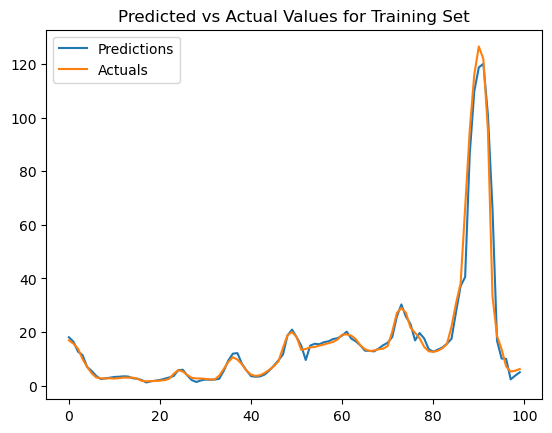

In [43]:
plt.plot(train_results2['Train Predictions'][:100])
plt.plot(train_results2['Actuals'][:100])
plt.title('Predicted vs Actual Values for Training Set')
plt.legend(['Predictions','Actuals']);

33. Calculate the predicted values for the validation set and add them to a dataframe along with the actuals.

In [44]:
val_predictions2 = model2.predict(X2_val).flatten()
val_results2 = pd.DataFrame(data={'Val Predictions': val_predictions2, 'Actuals': y2_val})
val_results2

94/94 [==============================] - 0s 2ms/step


,Val Predictions,Actuals
0,11.106468,5.95
1,1.927253,6.47
2,7.692346,8.21
3,8.310033,4.67
4,2.495635,4.16
...,...,...
2995,17.973845,17.85
2996,17.495237,18.36
2997,18.690393,18.85
2998,18.774139,16.84


34. Visualize the data to compare predicted values to the actual values for the validation set. For this set, it looks like the model did a little better at predicting that larger spike.

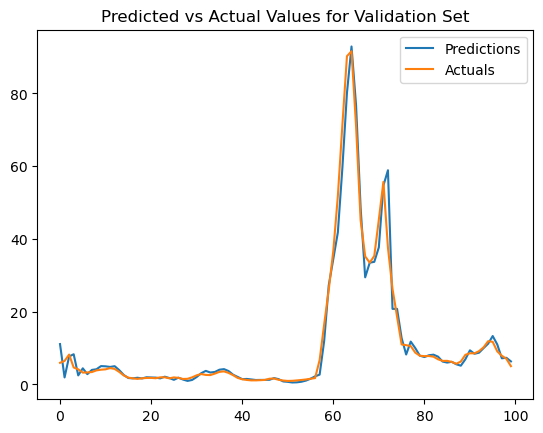

In [45]:
plt.plot(val_results2['Val Predictions'][:100])
plt.plot(val_results2['Actuals'][:100])
plt.title('Predicted vs Actual Values for Validation Set')
plt.legend(['Predictions','Actuals']);

35. Calculate the predicted values for the training set and add them to a dataframe along with the actuals.

In [46]:
test_predictions2 = model2.predict(X2_test).flatten()
test_results2 = pd.DataFrame(data={'Test Predictions': test_predictions2, 'Actuals': y2_test})
test_results2

96/96 [==============================] - 0s 3ms/step


,Test Predictions,Actuals
0,18.992447,19.42
1,19.243519,22.37
2,23.417957,26.01
3,26.463253,23.03
4,19.125601,17.09
...,...,...
3048,34.359097,36.08
3049,43.263874,45.75
3050,45.699394,50.21
3051,45.244827,48.14


36. Visualize the data to compare predicted values to the actual values for the testing set. For this set, it looks like the model's predictions overshot the actuals for the larger spikes.

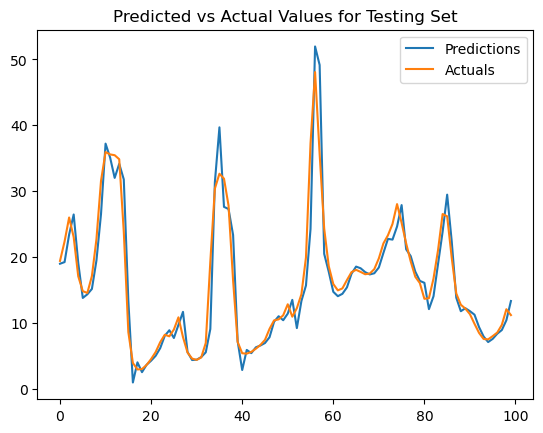

In [47]:
plt.plot(test_results2['Test Predictions'][:100])
plt.plot(test_results2['Actuals'][:100])
plt.title('Predicted vs Actual Values for Testing Set')
plt.legend(['Predictions','Actuals']);

37. Calculate the coefficient of determination for the training set, validation set, and testing set. As you can see, in general the model performed well, though it did not perform as well as that first model. The first model's values for training, validation, and testing were .99, .99, and .98 respectively, and now they are .94, .92, and .88. If you average all three scores for each model you get .98 and .91 respectively, so in general the second model did not improve. In this case, adding time features did not improve the model which suggests that they are not as necessary for predicting time series data with a LSTM model as compared to a XGBoost model. 

In [48]:
train2_r2 = r2_score(train_results2['Actuals'],train_results2['Train Predictions'])
train2_r2

0.945597119006861

In [49]:
val2_r2 = r2_score(val_results2['Actuals'],val_results2['Val Predictions'])
val2_r2

0.9267510685000838

In [50]:
test2_r2 = r2_score(test_results2['Actuals'],test_results2['Test Predictions'])
test2_r2

0.8826786509371772

38. Calculate the Mean Squared Error and the Root Mean Squared Error. As you can see, all three values are larger than the MSE values from the last model. This model's MSE for the testing set is 68.5, which is even larger than the MSE for the XGBoost model's test set of 40.62. 

In [75]:
realVals_train2 = train_results2.Actuals
predictedVals_train2 = train_results2['Train Predictions']
mse_train2 = mean_squared_error(realVals_train2, predictedVals_train2)
mse_train2

39.174193556569556

In [77]:
realVals_train2 = train_results2.Actuals
predictedVals_train2 = train_results2['Train Predictions']
rmse_train2 = mean_squared_error(realVals_train2, predictedVals_train2, squared = False)
rmse_train2

6.258929106210547

In [74]:
realVals_val2 = val_results2.Actuals
predictedVals_val2 = val_results2['Val Predictions']
mse_val2 = mean_squared_error(realVals_val2, predictedVals_val2)
mse_val2

7.728136411984027

In [78]:
realVals_val2 = val_results2.Actuals
predictedVals_val2 = val_results2['Val Predictions']
rmse_val2 = mean_squared_error(realVals_val2, predictedVals_val2, squared = False)
rmse_val2

2.7799525916792227

In [76]:
realVals_test2 = test_results2.Actuals
predictedVals_test2 = test_results2['Test Predictions']
mse_test2 = mean_squared_error(realVals_test2, predictedVals_test2)
mse_test2

68.4964599996537

In [79]:
realVals_test2 = test_results2.Actuals
predictedVals_test2 = test_results2['Test Predictions']
rmse_test2 = mean_squared_error(realVals_test2, predictedVals_test2, squared = False)
rmse_test2

8.276258816618395